In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Length of Hospital Stay by Admission Type

For the first visualization, I chose a to explore a simple but informative comparison of information that could be gathered from a single table. Following are two visualizations comparing the distribution of lengths of stay between hospital admission types. This information was found in the [MIMIC III Admissions table](https://mimic.mit.edu/docs/iii/tables/admissions/). Length of Stay was derived by taking the difference between the `DISCHTIME` and `ADMITTIME` columns, using units of hours.

## Histogram View

The first plot is a histogram where the X-Axis represents the length of stay, in hours and the Y-Axis represents the number of admissions with a Length of Stay corresponding to the X-Axis. Length of Stays are "binned" together to make bars. Lenght of Stay counts are stacked by Admission Type

## Violin Plot View

The histogram gives a decent view of the overall distribution, but a violin plot might make it easier to visually compare the distributions per admission type

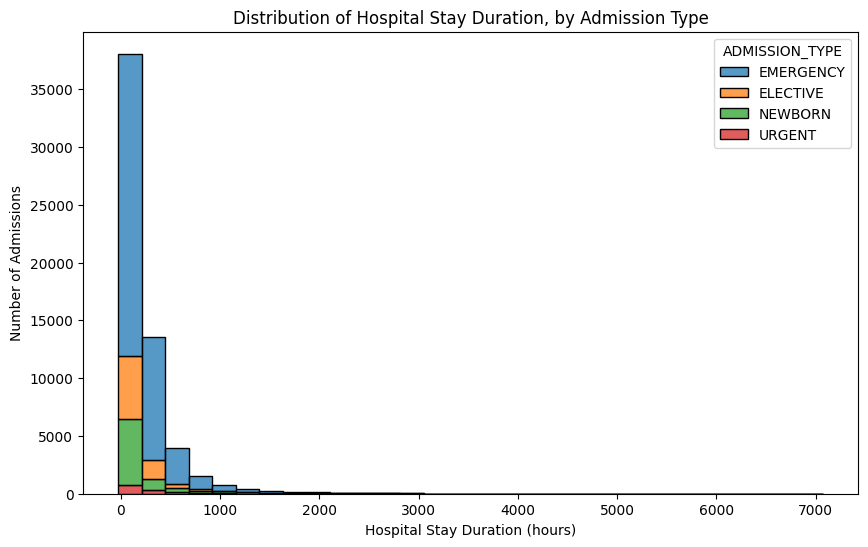

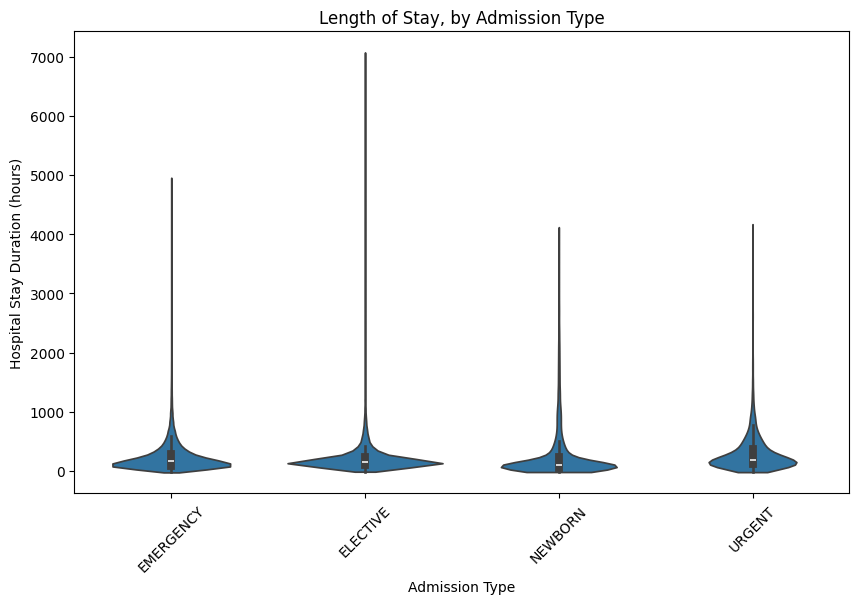

In [14]:
admissions = pd.read_csv("../mimic-iii/ADMISSIONS.csv.gz")

# convert timestamp columns to datetime
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])
admissions["DISCHTIME"] = pd.to_datetime(admissions["DISCHTIME"])
# add a column to hold calculated length of stay
admissions["STAYTIME_HRS"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds()/3600

plt.figure(figsize=(10,6))

# Histogram View
sns.histplot(
    data=admissions,
    x="STAYTIME_HRS",
    hue="ADMISSION_TYPE",
    bins=30,         # adjust as needed
    multiple="stack" # stack bars instead of overlay
)

plt.xlabel("Hospital Stay Duration (hours)")
plt.ylabel("Number of Admissions")
plt.title("Distribution of Hospital Stay Duration, by Admission Type")
plt.show()

plt.figure(figsize=(10,6))
# Violin Plot View
sns.violinplot(
    data=admissions,
    x="ADMISSION_TYPE",
    y="STAYTIME_HRS",
    inner="box",    # shows median and IQR inside violin
    cut=0           # avoids extending beyond observed values
)

plt.xlabel("Admission Type")
plt.ylabel("Hospital Stay Duration (hours)")
plt.title("Length of Stay, by Admission Type")
plt.xticks(rotation=45)  # rotate labels if they overlap
plt.show()




